# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns

import transformer_lens as tl
from circuit_finder.data_loader import load_datasets_from_json

from circuit_finder.pretrained import (
    load_attn_saes,
    load_resid_saes,
    load_hooked_mlp_transcoders,
)
from circuit_finder.core.hooked_transcoder import HookedTranscoderReplacementContext
from circuit_finder.utils import get_answer_tokens, logits_to_ave_logit_diff
from circuit_finder.constants import device, ProjectDir

In [3]:
model = tl.HookedSAETransformer.from_pretrained("gpt2")

data_path = ProjectDir / "datasets" / "ioi" / "ioi_vanilla_template_prompts.json"
train_loader, test_loader = load_datasets_from_json(
    model=model,
    path=data_path,
    device=device,
    prepend_bos=True,
    batch_size=128,
    train_test_size=(128, 128),
)

/workspace/circuit-finder/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


In [4]:
batch = next(iter(train_loader))

In [5]:
sns.set_theme()

# Sanity check SAEs

## Attention SAEs

In [6]:
attn_saes = load_attn_saes()

In [7]:


loss_with_sae = {}

for layer, sae in attn_saes.items():
    with model.saes(sae):
        loss, _ = model.run_with_cache(batch.clean, return_type = 'loss')
        loss_with_sae[layer] = loss.item()

print(loss_with_sae)

{0: 4.4648261070251465, 1: 4.457442283630371, 2: 4.454837322235107, 3: 4.427687168121338, 4: 4.433335304260254, 5: 4.431800365447998, 6: 4.439744472503662, 7: 4.407613754272461, 8: 4.4077582359313965, 9: 4.432715892791748, 10: 4.429360866546631, 11: 4.484189987182617}


In [8]:
loss_orig, _ = model.run_with_cache(batch.clean, return_type = 'loss')
print(loss_orig.item())

4.44209623336792


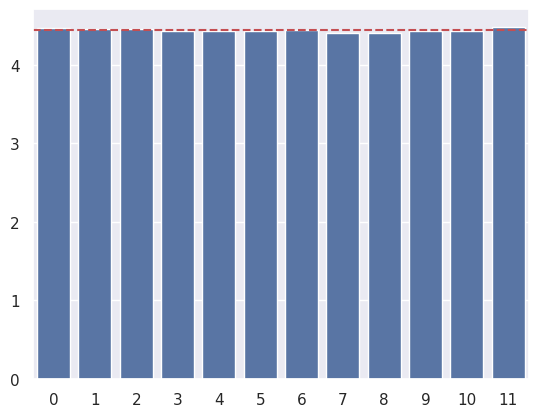

In [9]:
import matplotlib.pyplot as plt

sns.barplot(
    x=list(loss_with_sae.keys()),
    y=list(loss_with_sae.values()),
)
plt.axhline(y=loss_orig.item(), color='r', linestyle='--')

## MLP Transcoders

In [10]:
mlp_transcoders = load_hooked_mlp_transcoders()

loss_orig, _ = model.run_with_cache(batch.clean, return_type="loss")

loss_with_sae = {}
for layer, transcoder in mlp_transcoders.items():
    with HookedTranscoderReplacementContext(model, [transcoder]):
        loss, _ = model.run_with_cache(batch.clean, return_type="loss")
        loss_with_sae[layer] = loss.item()

Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Loss when replacing MLP with Transcoders')

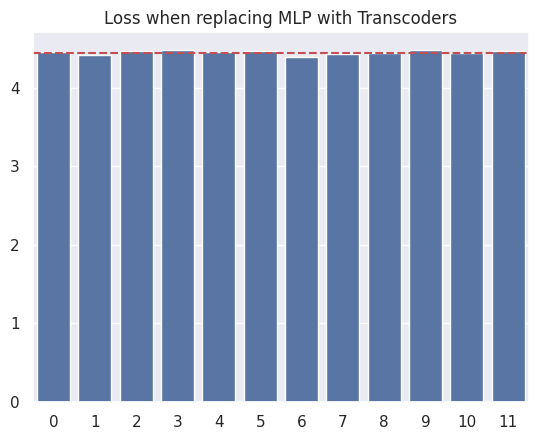

In [11]:
sns.barplot(
    x=list(loss_with_sae.keys()),
    y=list(loss_with_sae.values()),
)
plt.axhline(y=loss_orig.item(), color="r", linestyle="--")
plt.title("Loss when replacing MLP with Transcoders")

## Residual SAEs

In [12]:
resid_saes = load_resid_saes()


loss_with_sae = {}

loss_orig, _ = model.run_with_cache(batch.clean, return_type="loss")
for layer, sae in attn_saes.items():
    with model.saes(sae):
        loss, _ = model.run_with_cache(batch.clean, return_type="loss")
        loss_with_sae[layer] = loss.item()

100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Text(0.5, 1.0, 'Loss with Resid SAE Reconstruction')

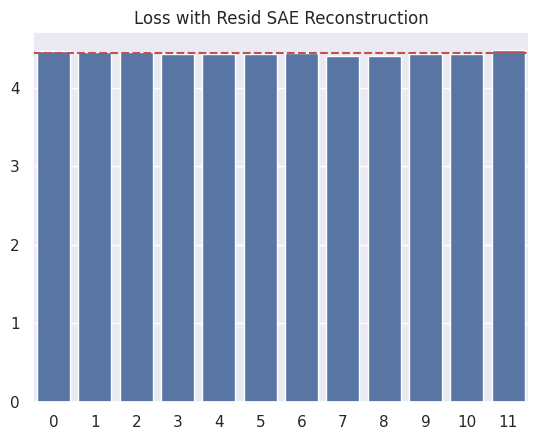

In [15]:
sns.barplot(
    x=list(loss_with_sae.keys()),
    y=list(loss_with_sae.values()),
)
plt.axhline(y=loss_orig.item(), color="r", linestyle="--")
plt.title("Loss with Resid SAE Reconstruction")